In [2]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from InterObject import * 
from Global import * 

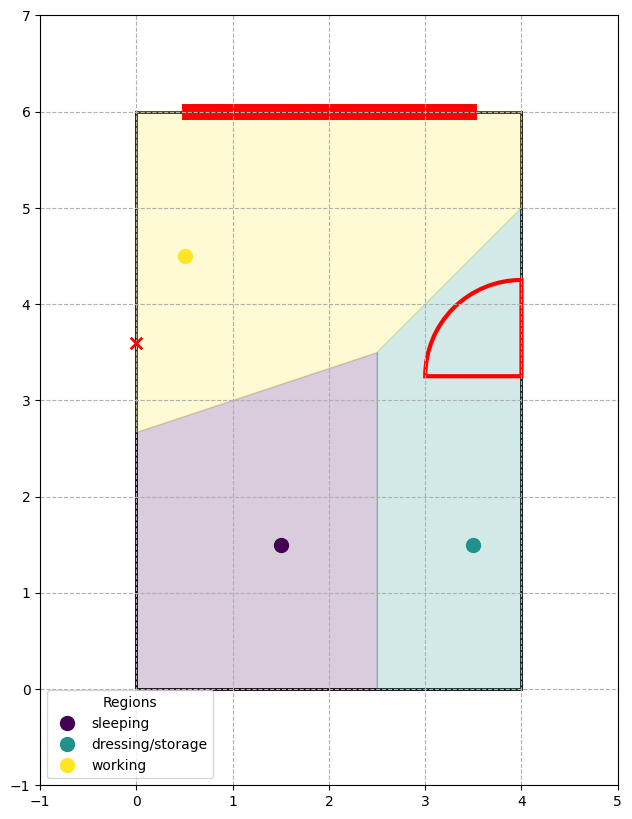

In [12]:
room = create_room(4, 6)
create_fixed_object(room, 'window', 3, 0.1, 'north', position = 0.5)
create_fixed_object(room, 'door', 1, 0.1, 'east', position = 0.65)
create_fixed_object(room, 'socket', 0.1, 0.05, 'west', position = 0.6)

region_setup(room, 'sleeping', 0)
region_setup(room, 'dressing/storage', 1)
region_setup(room, 'working', 2)

room.regions[0].x, room.regions[0].y = [1.5, 1.5]
room.regions[1].x, room.regions[1].y = [3.5, 1.5]
room.regions[2].x, room.regions[2].y = [0.5, 4.5]

room.draw(draw_regions = True)

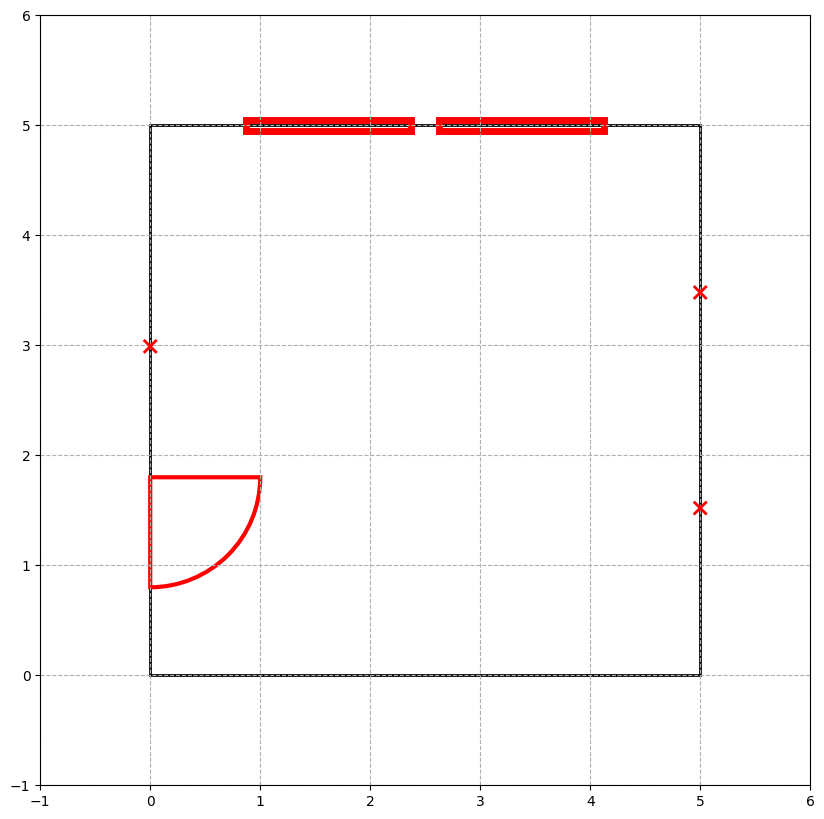

New best result found. Cost:  2.626406458926671
New best result found. Cost:  2.6168627370984843
New best result found. Cost:  2.616840803178712
New best result found. Cost:  2.6168407900356034


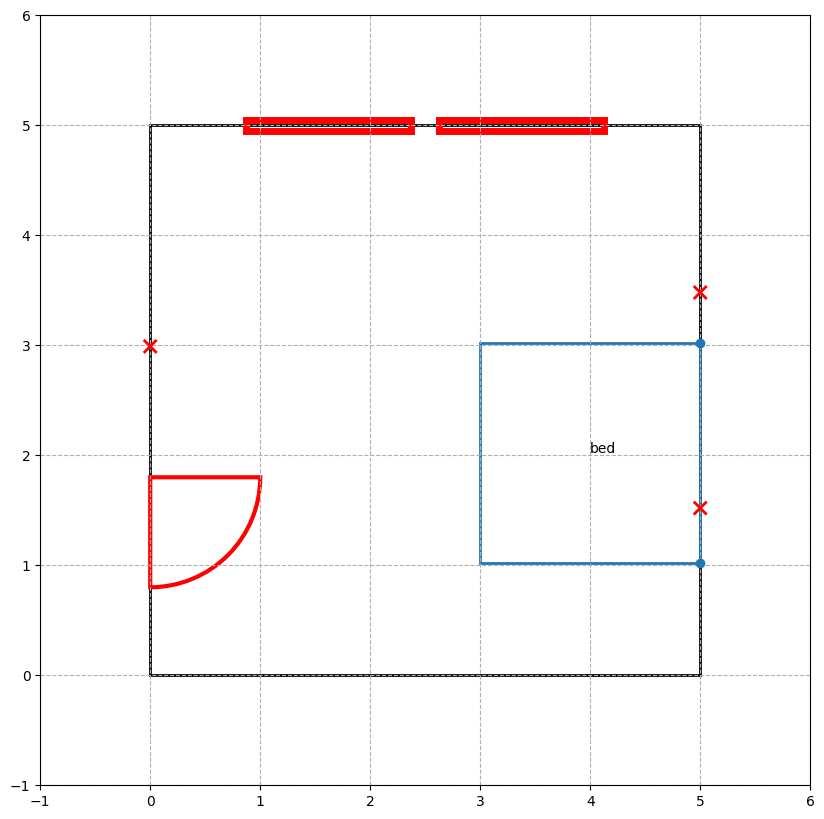

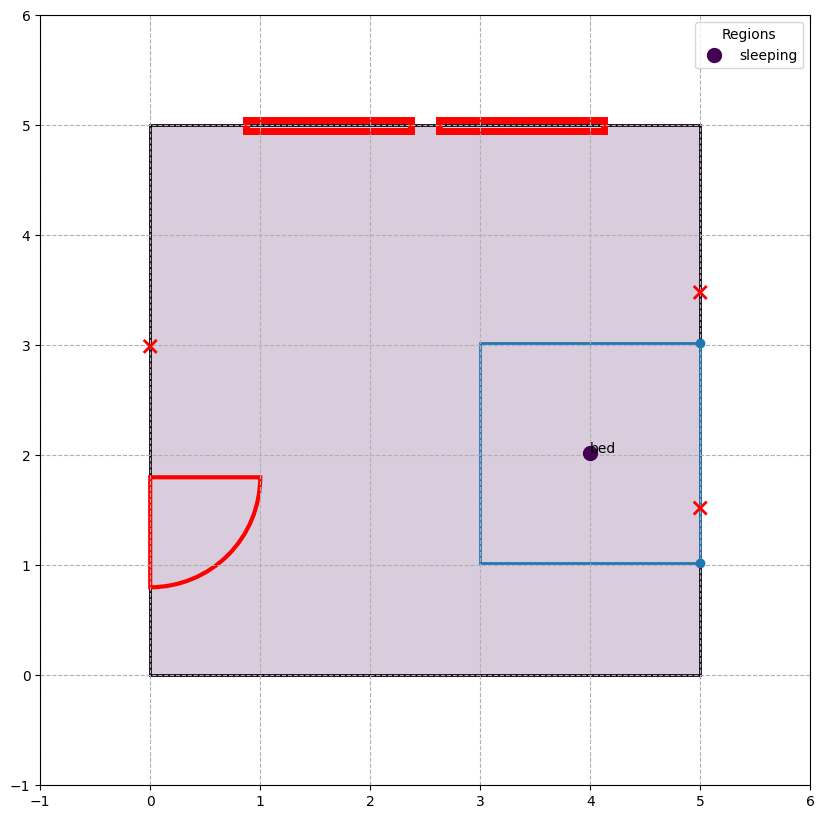

New best result found. Cost:  8.319965463153268 overlap:  0 bounds:  0.2554596857301745
New best result found. Cost:  1.2915864528164105 overlap:  0.00728804218553166 bounds:  5.083422366534798e-06


/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/InterObject.py:59: RuntimeWarning: invalid value encountered in arccos
  angle_diff = np.arccos(np.dot(direction1, direction2)/(np.linalg.norm(direction1)*np.linalg.norm(direction2)))


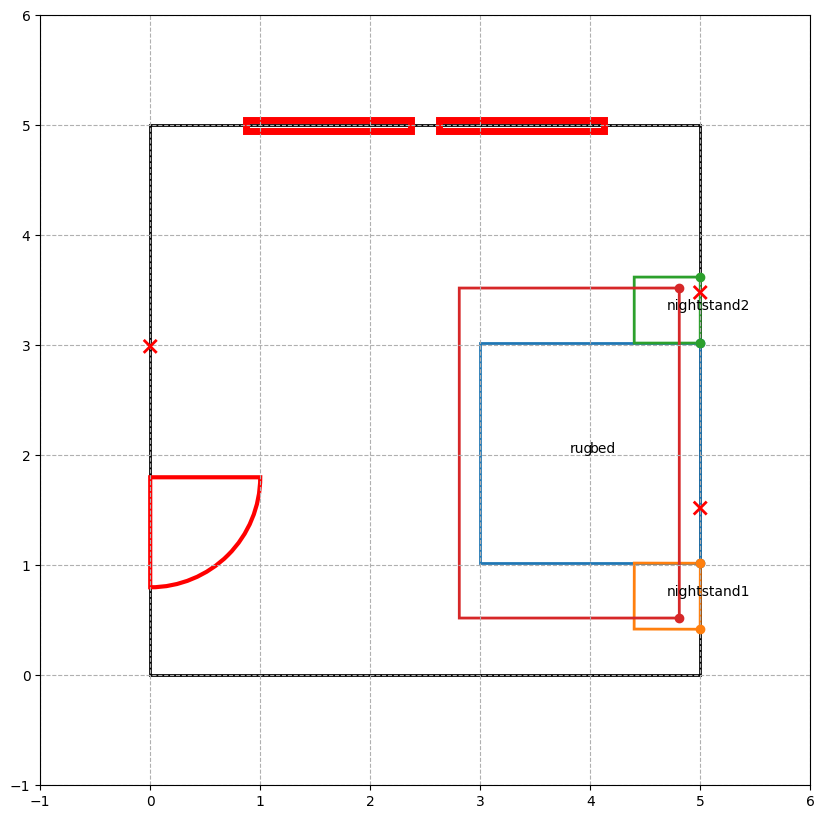

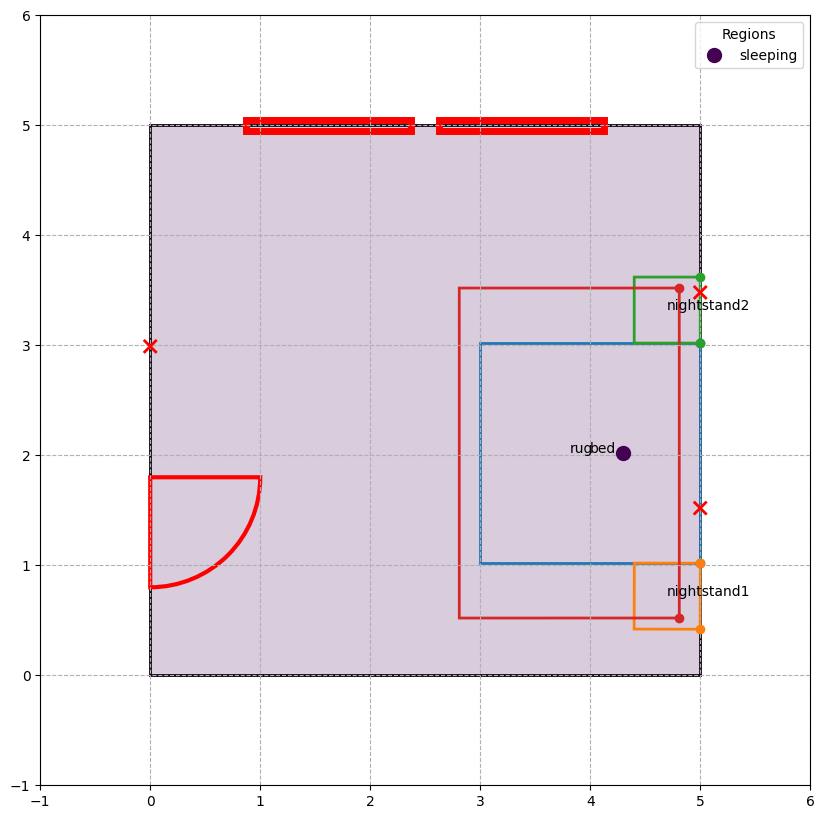

In [7]:
room = create_room(5, 5)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(room, 'door', 1, 0.1, 'west', position = 0.2)
create_fixed_object(room, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.7)
room.draw()

options = {'maxiter': 300, 'ftol': 1e-6}
sleep = region_setup(room, 'sleeping', 0)
create_moving_object(room, 'bed', 2, 2, 'sleeping', 0)

def optimize_primary_objects(positions, room): 
    
    output = 0
    output += ind_next_to_wall(positions, room, 0, 'back')  # bed
    output += ind_close_to_fixed_object(positions, room, 0, 'socket', side = 'back')
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_away_from_fixed_object(positions, room, 0, 'door')
    output += ind_central(positions, room, 0)
    output += ind_accessible(positions, room, 0, ['left', 'right'])  # bed
    output += aligned(positions, room)
    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += balanced(positions, room)

    return output

iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 100:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects, positions, args = (room), method = 'SLSQP', options = options) 
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.4:
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)

    
for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
room.draw() 

room.regions[0].x, room.regions[0].y = room.moving_objects[0].position[0], room.moving_objects[0].position[1]

room.draw(draw_regions = True)
prev_cost = min_fun 

room.fm_indices += [0]

create_moving_object(room, 'nightstand1', 0.6, 0.6, 'sleeping', 1)
create_moving_object(room, 'nightstand2', 0.6, 0.6, 'sleeping', 2)
create_moving_object(room, 'rug', 3, 2, 'sleeping', 3)

def optimize_secondary_objects(positions, room):
    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'right'])/2

    output += ind_next_to_wall(positions, room, 1, 'back')  # nightstand1
    output += ind_next_to_wall(positions, room, 2, 'back')  # nightstand2
    output += io_between(positions, room, 0, 1, 2)  # nightstand1, nightstand2
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += io_next_to(positions, room, 1, 0, 'right', 'left')  # nightstand1, bed
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2

    output += io_under_central(positions, room, 3, 0) #rug, bed
    output += ind_not_against_wall(positions, room, 3) # rug

    output += ind_in_region(positions, room, 1, 'sleeping')
    output += ind_in_region(positions, room, 2, 'sleeping')
    output += ind_in_region(positions, room, 3, 'sleeping')

    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += aligned(positions, room)

    return output

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 5e-2 and iters < 100:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 1e-2 and not in_bounds(res.x, room) > 0.4:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 
room.draw() 

room.regions[0].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'sleeping'])
room.regions[0].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'sleeping'])

room.draw(draw_regions = True)

room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]
prev_cost = min_fun 

New best result found. Cost:  7.781689496964999 overlap:  0.00728804218553166 bounds:  0.09986304708122394
New best result found. Cost:  6.03022434223964 overlap:  0.00728804218553166 bounds:  0.15492286177100006
New best result found. Cost:  3.713357147007827 overlap:  0.00728804218553166 bounds:  1.035567750820947e-05
New best result found. Cost:  3.7094550817686383 overlap:  0.00728804218553166 bounds:  0.0012188529406478848
New best result found. Cost:  3.7083350846343563 overlap:  0.00728804218553166 bounds:  5.25073425688318e-05
New best result found. Cost:  3.708290373070828 overlap:  0.00728804218553166 bounds:  0.00013124698416171356


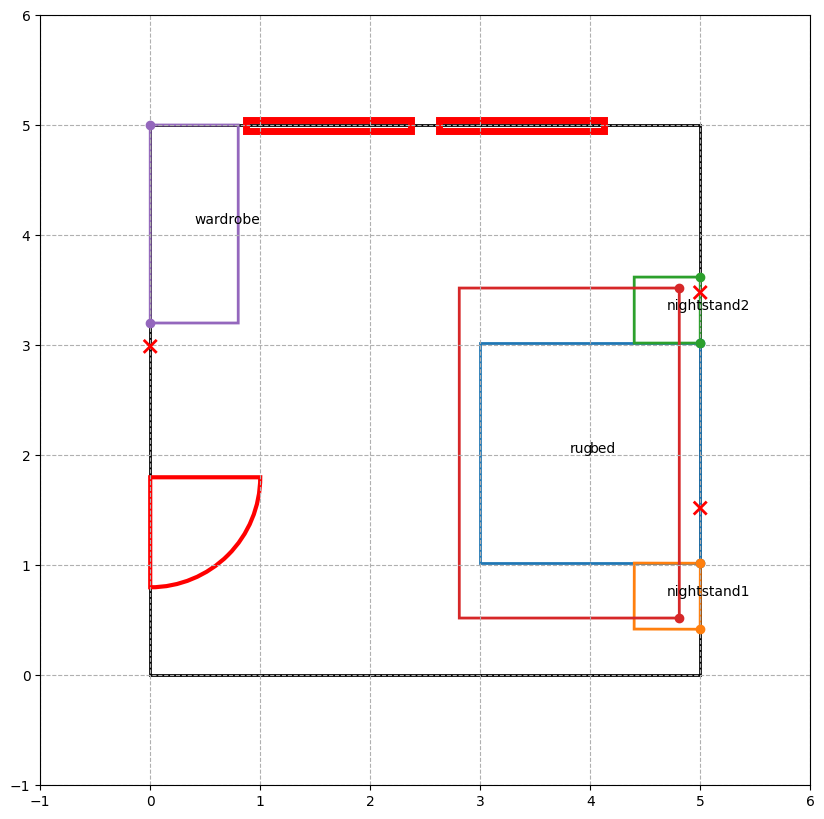

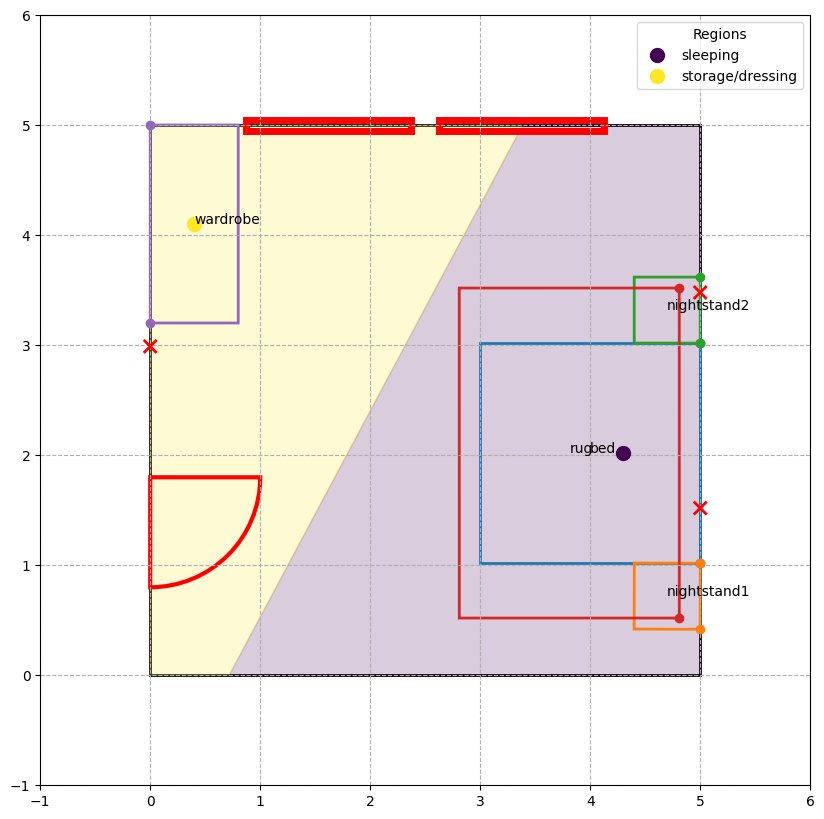

New best result found. Cost:  4.47010409644629 overlap:  0.00728804218553166 bounds:  0.00013124698416171356
New best result found. Cost:  4.149402000560179 overlap:  0.00728804218553166 bounds:  0.00013386602687767547
New best result found. Cost:  3.5119272097088388 overlap:  0.00728804218553166 bounds:  0.00013124698416171356
New best result found. Cost:  3.5090330365224336 overlap:  0.00728804218553166 bounds:  0.00013124789374649988


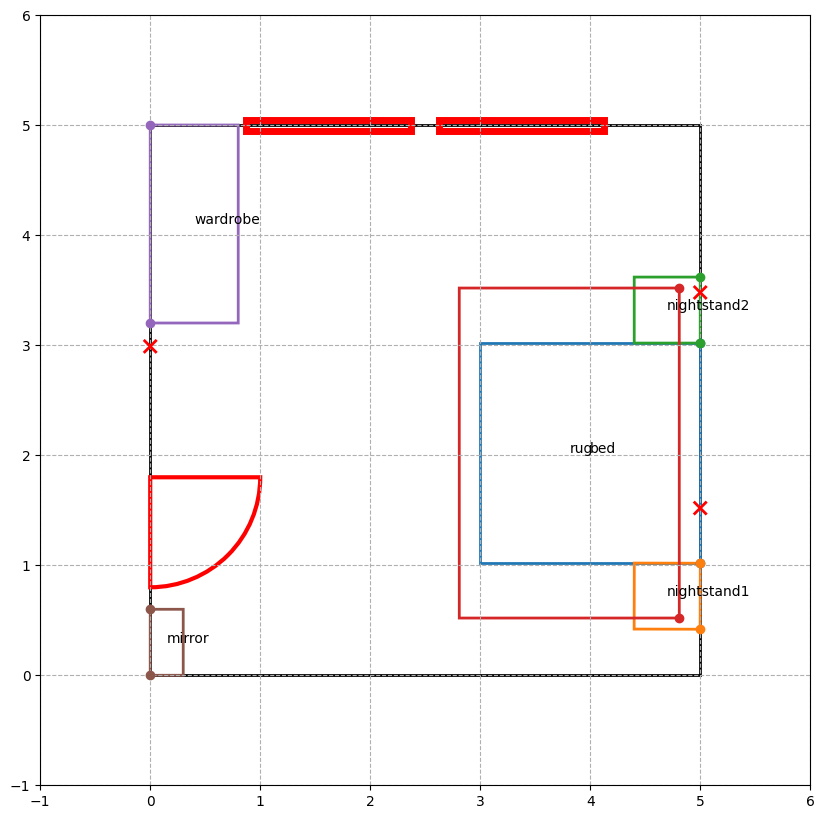

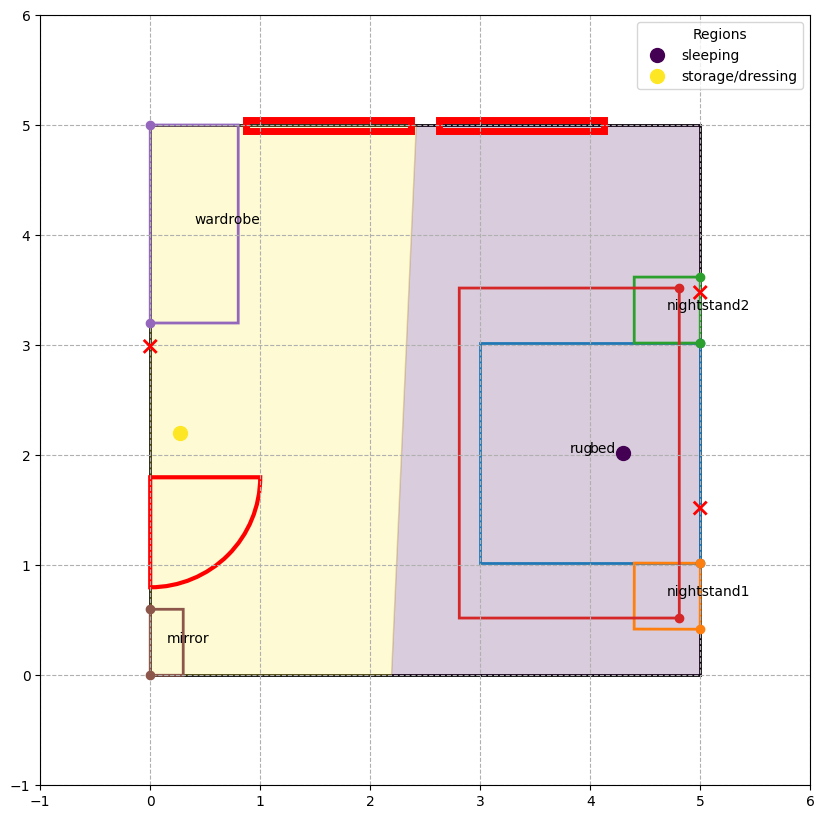

In [8]:
## Region 2

options = {'maxiter': 150, 'ftol': 1e-5}
storage = region_setup(room, 'storage/dressing', 1)
create_moving_object(room, 'wardrobe', 1.8, 0.8, 'storage/dressing', 4)

def optimize_primary_objects3(positions, room):
    output = 0

    output += ind_accessible(positions, room, 0, ['left', 'right', 'front'])  # bed
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2
    
    output += ind_next_to_wall(positions, room, 4, 'back')  # wardrobe
    output += ind_accessible(positions, room, 4, ['front'])
    output += ind_not_block_fixed_object(positions, room, 4, 'window')

    output += io_away_from(positions, room, 4, 0)  # wardrobe, bed

    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += balanced(positions, room)
    output += aligned(positions, room)

    return output

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 30:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects3, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not in_bounds(res.x, room) > 0.3:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))

for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 
room.draw()
room.regions[1].x, room.regions[1].y = room.moving_objects[4].position[0], room.moving_objects[4].position[1]
room.draw(draw_regions = True) 
prev_cost = min_fun

room.fm_indices += [4]
create_moving_object(room, 'mirror', 0.6, 0.3, 'storage/dressing', 5)

def optimize_secondary_objects3(positions, room):

    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'right', 'front'])  # bed
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2
    output += ind_accessible(positions, room, 4, ['front'])  # wardrobe

    output += ind_in_region(positions, room, 5, 'storage/dressing')
    output += ind_next_to_wall(positions, room, 5, 'back')  # mirror
    output += ind_accessible(positions, room, 5, ['front'])
    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += balanced(positions, room)
    output += aligned(positions, room)
    output += io_not_facing(positions, room, 5, 0)
    output += ind_not_block_fixed_object(positions, room, 5, 'window')

    return output 

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 30:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects3, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not in_bounds(res.x, room) > 0.3:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 

room.draw() 


room.regions[1].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'storage/dressing'])
room.regions[1].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'storage/dressing'])
room.draw(draw_regions = True)
room.fm_indices += [5]

New best result found. Cost:  4.494795561195123 overlap:  0.00728804218553166 bounds:  0.00016493696521540258
New best result found. Cost:  4.485441223567728 overlap:  0.00728804218553166 bounds:  0.00013125154303204441


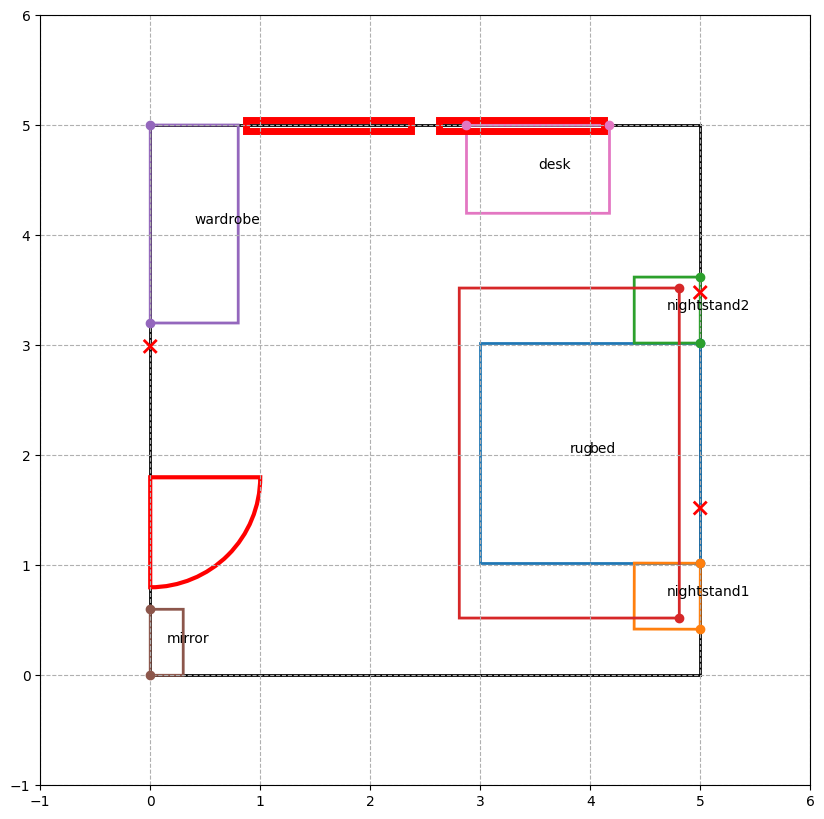

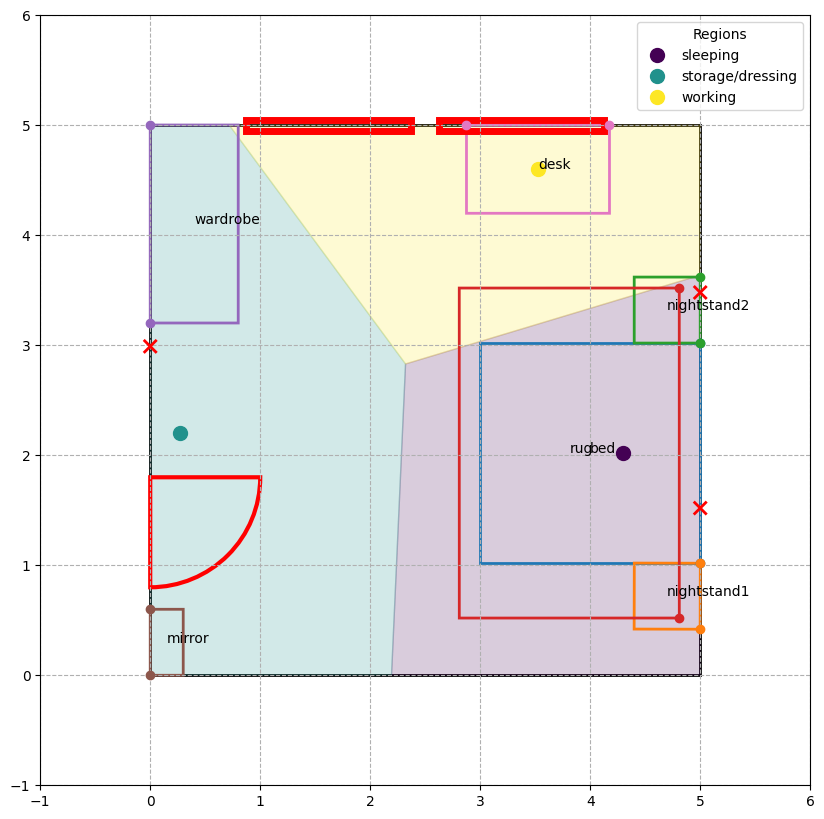

New best result found. Cost:  3.989782598687794 overlap:  0.007448934321193347 bounds:  0.00013125154303204441


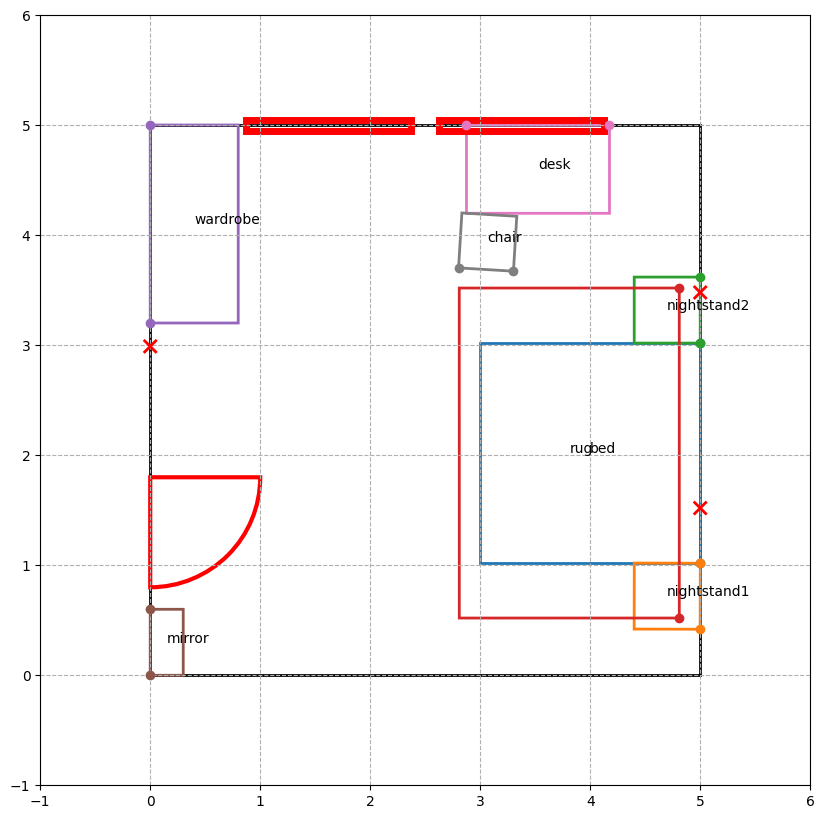

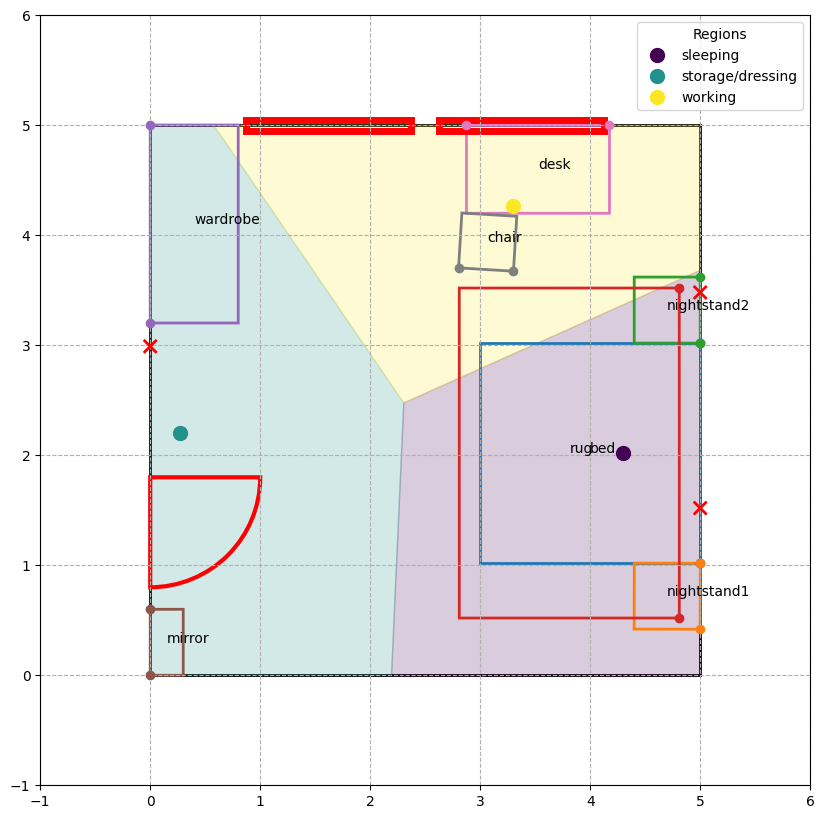

In [9]:
## Region 2
working = region_setup(room, 'working', 2)
create_moving_object(room, 'desk', 1.3, 0.8, 'working', 6)

def optimize_primary_objects2(positions, room):
    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'right', 'front'])  # bed
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2
    
    output += ind_next_to_wall(positions, room, 6, 'back')  # desk
    output += ind_close_to_fixed_object(positions, room, 6, 'window')
    output += ind_under_window(positions, room, 6)
    output += io_away_from(positions, room, 6, 0)  # desk, bed
    output += io_away_from(positions, room, 6, 4)  # wardrobe, desk

    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += balanced(positions, room)
    output += aligned(positions, room)

    return output

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 30:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects2, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not in_bounds(res.x, room) > 0.3:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 
room.draw() 

room.regions[2].x, room.regions[2].y = room.moving_objects[6].position[0], room.moving_objects[6].position[1]
prev_cost = min_fun

room.draw(draw_regions = True)

room.fm_indices += [6]
create_moving_object(room, 'chair', 0.5, 0.5, 'working', 7)

def optimize_secondary_objects2(positions, room):

    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'right'])  # bed
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2

    output += io_next_to(positions, room, 7, 6, 'front', 'front')
    output += io_facing(positions, room, 7, 6, both = True)
    output += ind_in_region(positions, room, 7, 'working')

    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += balanced(positions, room)
    output += aligned(positions, room)

    return output 

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 30:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects2, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        min_fun = res.fun 
        best_res = res
        print("New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 
room.draw() 
prev_cost = 1.0 * min_fun 

room.regions[2].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'working'])
room.regions[2].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'working'])
room.draw(draw_regions = True)
room.fm_indices += [7]

In [10]:
for i in range(len(room.moving_objects)): 
    print(room.moving_objects[i].name, room.moving_objects[i].position)

bed [3.99999993 2.01999815 1.57079625]
nightstand1 [4.70000764 0.71935632 1.56844244]
nightstand2 [4.70000001 3.32000331 1.57078561]
rug [3.80960429 2.02034731 1.57089316]
wardrobe [0.39999812 4.10251161 4.71239135]
mirror [0.1500043  0.29999365 4.71240409]
desk [3.52519253 4.6000121  3.14158343]
chair [ 3.06766335  3.93811213 -0.06065314]


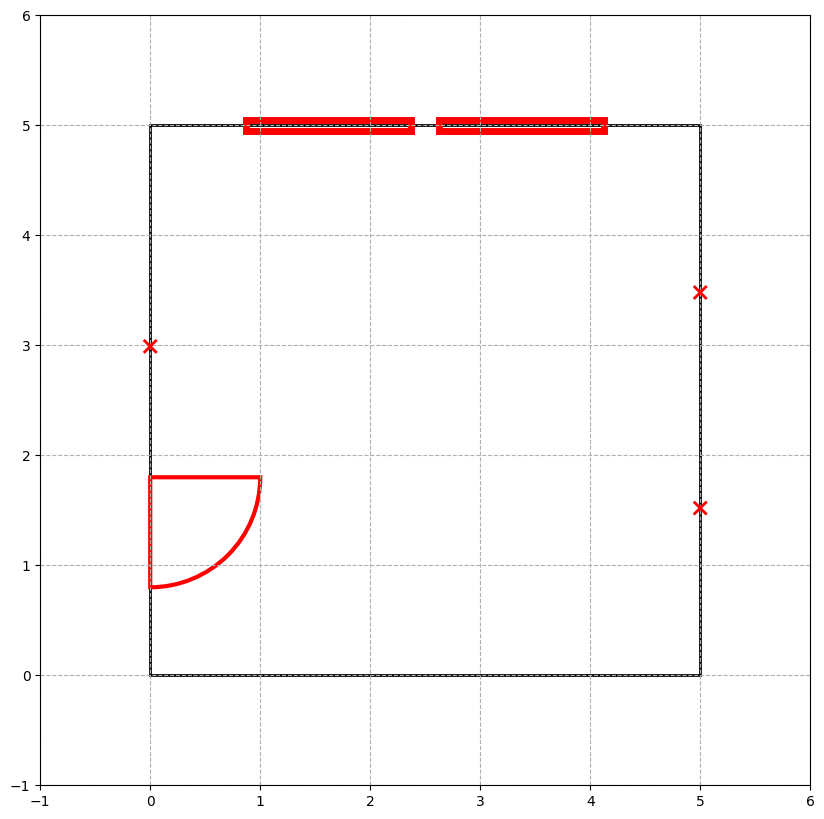

New best result found. Cost:  15.162427410941955
New best result found. Cost:  15.061321351851289
New best result found. Cost:  5.184362005451421
New best result found. Cost:  4.041291305003261
New best result found. Cost:  3.5775420278292906
New best result found. Cost:  1.5498050227367393


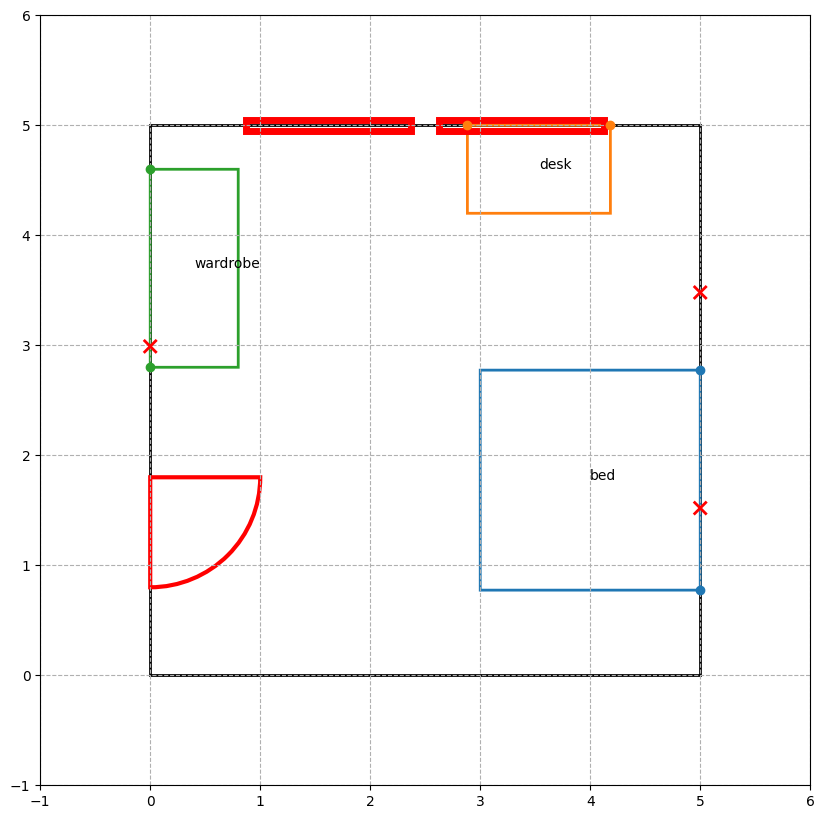

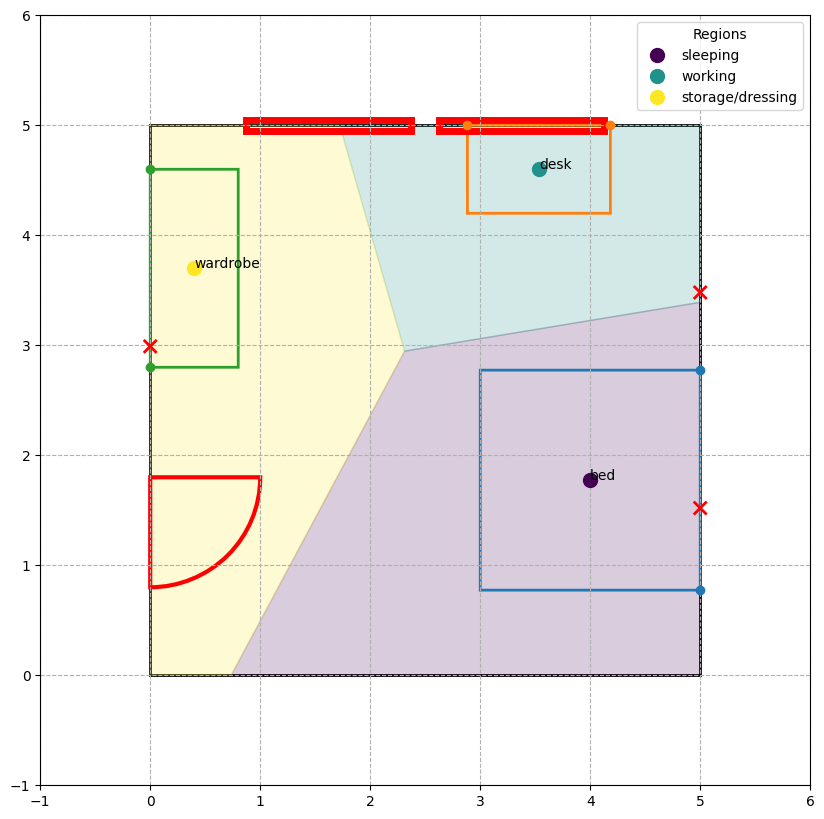

New best result found. Cost:  7.7285271031430955 overlap:  0 bounds:  4.5422540096376934e-07
New best result found. Cost:  3.8902775704158756 overlap:  0 bounds:  0.002280134617068174


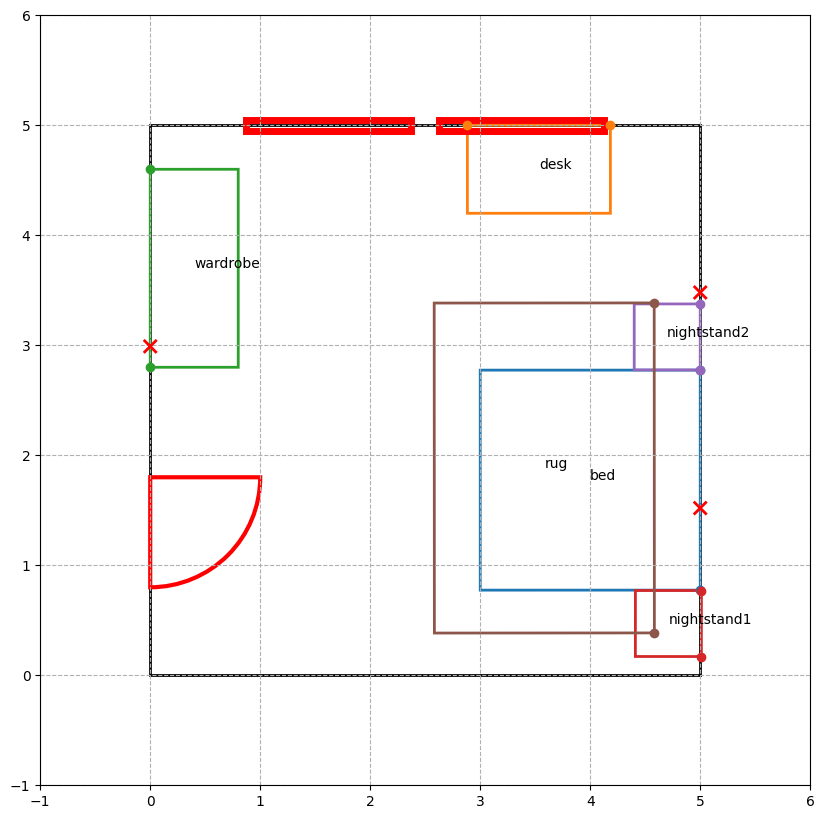

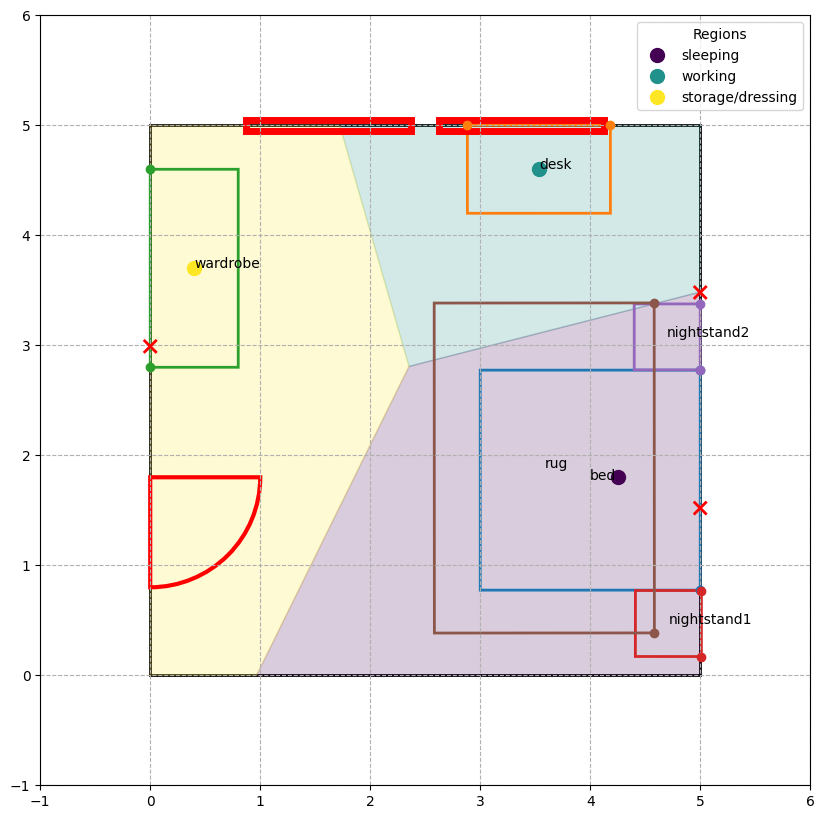

New best result found. Cost:  5.525646784730532 overlap:  0 bounds:  0.2670265791227001
New best result found. Cost:  4.945088837807159 overlap:  0 bounds:  0.002280134617068174
New best result found. Cost:  4.485530570363763 overlap:  0 bounds:  0.002280134617068174
New best result found. Cost:  4.177161891236737 overlap:  0 bounds:  0.002280134617068174


/Users/gabriellelittlefair/miniforge3/envs/MV00/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/25/n8z44f7d4tn9463r4xj1ncv00000gn/T/ipykernel_52649/1910996512.py:53: RuntimeWarning: invalid value encountered in arccos
  angle_diff = np.arccos(np.dot(direction1, direction2)/(np.linalg.norm(direction1)*np.linalg.norm(direction2)))


New best result found. Cost:  4.176566405929601 overlap:  0 bounds:  0.002280134617068174


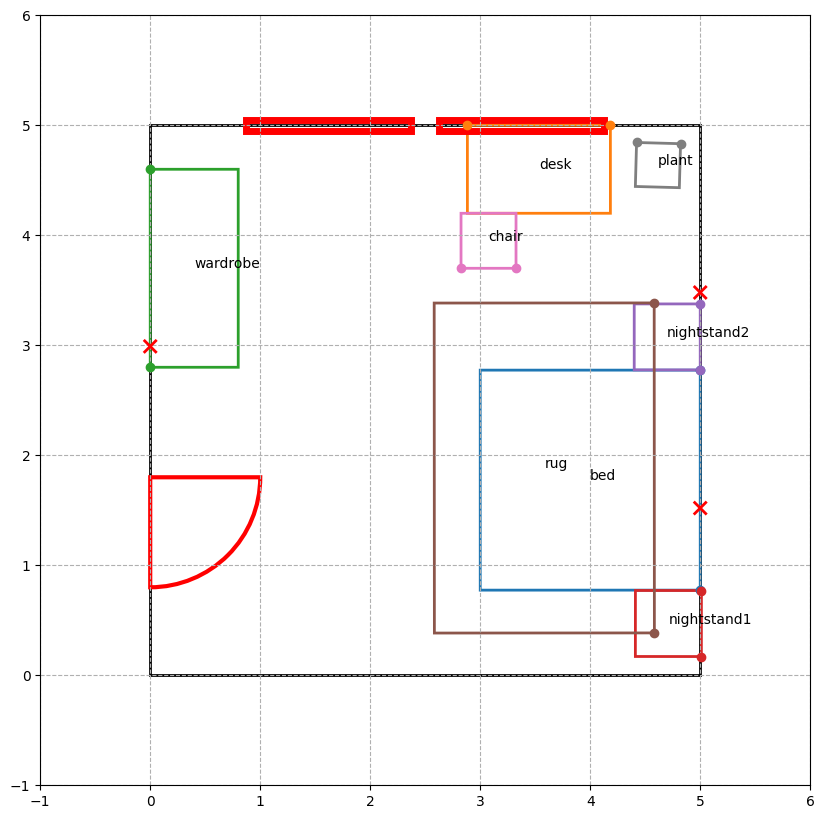

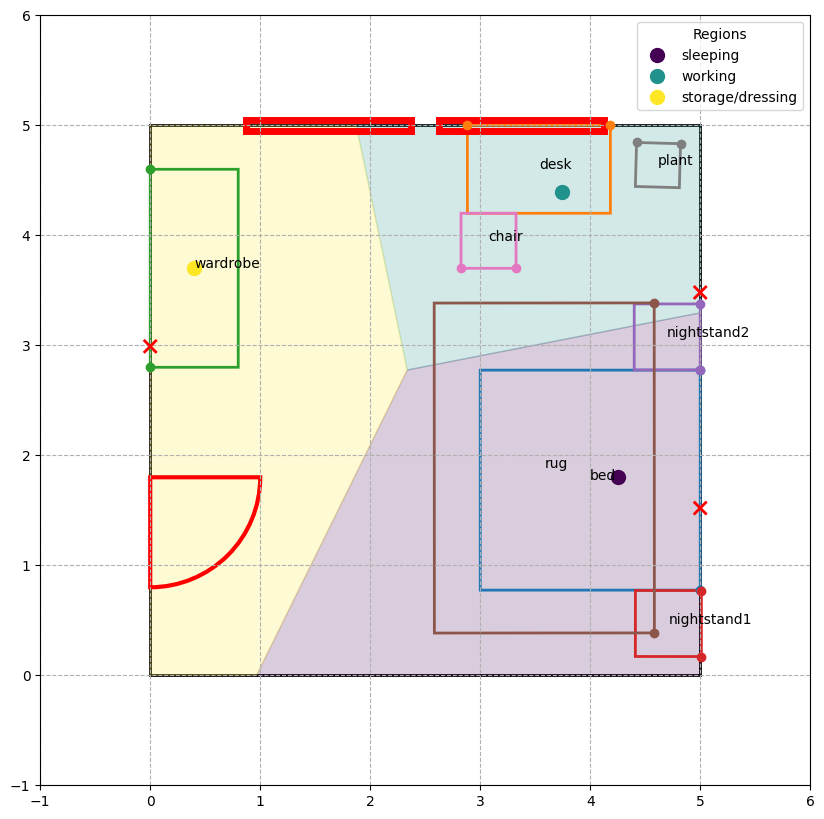

New best result found. Cost:  3.8282419791564988 overlap:  0 bounds:  0.002280134617068174
New best result found. Cost:  3.828238485267492 overlap:  0 bounds:  0.002280134617068174


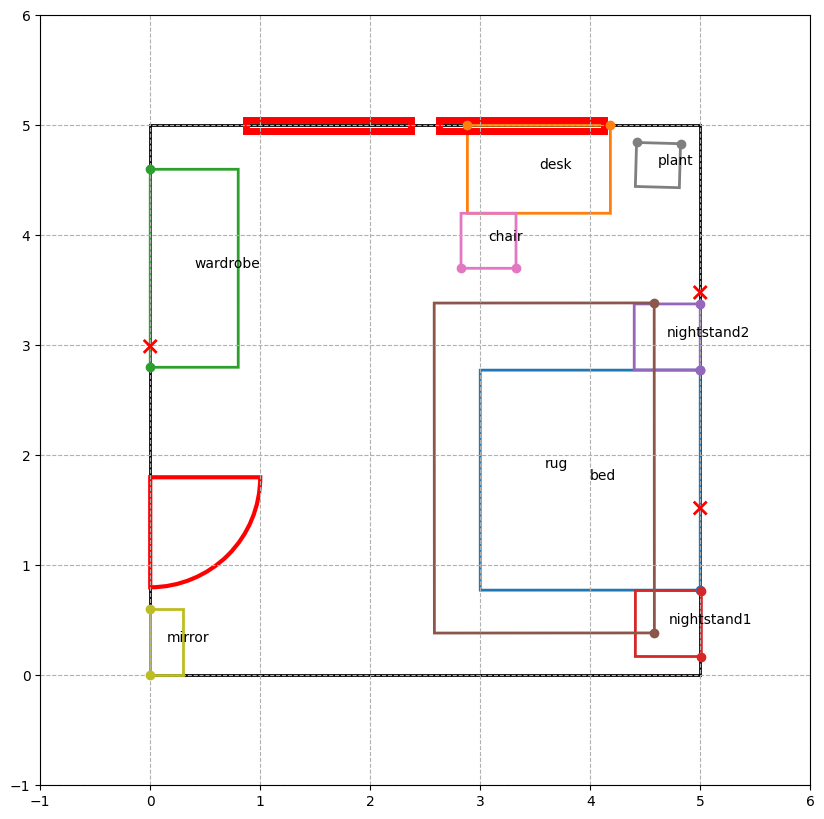

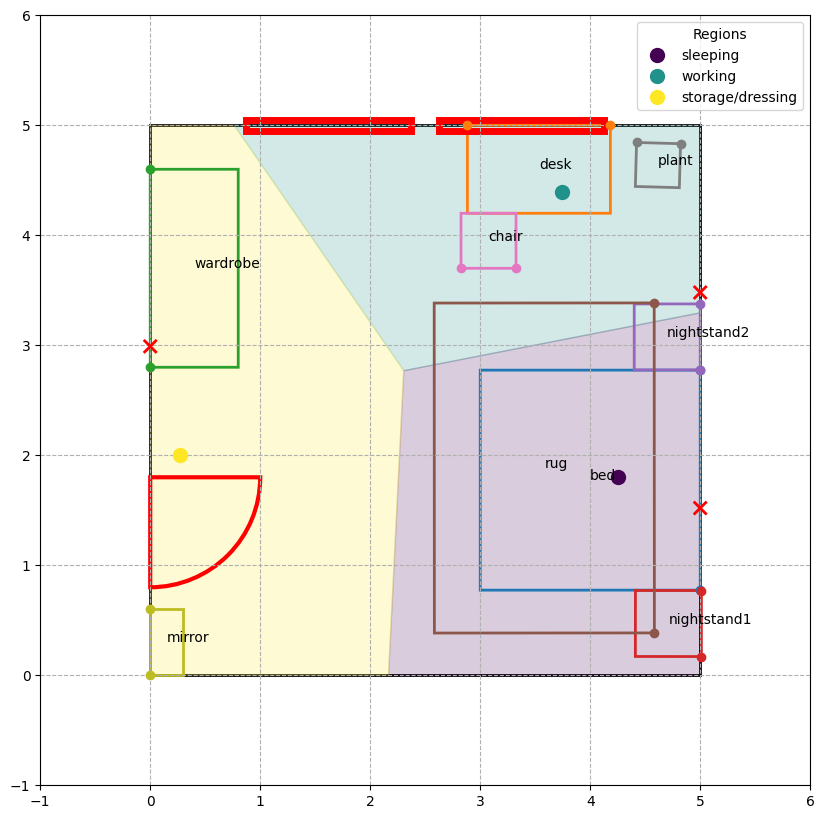

In [41]:
room = create_room(5, 5)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(room, 'door', 1, 0.1, 'west', position = 0.2)
create_fixed_object(room, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.7)
room.draw()

options = {'maxiter': 300, 'ftol': 1e-6}
## Region 1
region_setup(room, 'sleeping', 0)
create_moving_object(room, 'bed', 2, 2, 'sleeping', 0)
## Region 2
working = region_setup(room, 'working', 1)
create_moving_object(room, 'desk', 1.3, 0.8, 'working', 1)
## Region 3
storage = region_setup(room, 'storage/dressing', 2)
create_moving_object(room, 'wardrobe', 1.8, 0.8, 'storage/dressing', 2)

def optimize_primary_objects(positions, room): 
    
    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'right'])  # bed
    output += ind_accessible(positions, room, 2, ['front'])
    output += ind_next_to_wall(positions, room, 0, 'back')  # bed
    output += ind_close_to_fixed_object(positions, room, 0, 'socket', side = 'back')
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_away_from_fixed_object(positions, room, 0, 'door')
    output += ind_central(positions, room, 0)
    
    output += ind_next_to_wall(positions, room, 1, 'back')  # desk
    output += ind_close_to_fixed_object(positions, room, 1, 'window')
    output += ind_under_window(positions, room, 1)
    output += io_away_from(positions, room, 1, 0)  # desk, bed
    
    output += ind_next_to_wall(positions, room, 2, 'back')  # wardrobe
    output += ind_not_block_fixed_object(positions, room, 2, 'window')

    output += io_away_from(positions, room, 2, 0)  # wardrobe, bed
    output += io_away_from(positions, room, 2, 1)  # wardrobe, desk

    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += balanced(positions, room)
    output += aligned(positions, room)

    return output

iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 100:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects, positions, args = (room), method = 'SLSQP', options = options) 
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.4:
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)

    
for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
room.draw() 

for i in range(3):
    room.regions[i].x, room.regions[i].y = room.moving_objects[i].position[0], room.moving_objects[i].position[1]


room.draw(draw_regions = True)
prev_cost = min_fun 

room.fm_indices += [0, 1, 2]

create_moving_object(room, 'nightstand1', 0.6, 0.6, 'sleeping', 3)
create_moving_object(room, 'nightstand2', 0.6, 0.6, 'sleeping', 4)
create_moving_object(room, 'rug', 3, 2, 'sleeping', 5)

def optimize_secondary_objects(positions, room):
    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'right'])  # bed
    output += ind_accessible(positions, room, 2, ['front'])

    output += ind_next_to_wall(positions, room, 3, 'back')  # nightstand1
    output += ind_next_to_wall(positions, room, 4, 'back')  # nightstand2
    output += p_between(positions, room, 0, 3, 4)  # nightstand1, nightstand2
    output += p_next_to(positions, room, 3, 0, 'right', 'left')  # nightstand1, bed
    output += p_next_to(positions, room, 4, 0, 'left', 'right') 

    output += p_under_central(positions, room, 5, 0) # rug, bed
    output += ind_not_against_wall(positions, room, 5) # rug

    output += ind_in_region(positions, room, 3, 'sleeping')
    output += ind_in_region(positions, room, 4, 'sleeping')
    output += ind_in_region(positions, room, 5, 'sleeping')

    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += aligned(positions, room)
    output += balanced(positions, room)

    return output

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 5e-2 and iters < 100:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 1e-2 and not in_bounds(res.x, room) > 1e-2:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 
room.draw() 

room.regions[0].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'sleeping'])
room.regions[0].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'sleeping'])

room.draw(draw_regions = True)

room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]
prev_cost = min_fun 


create_moving_object(room, 'chair', 0.5, 0.5, 'working', 6)
create_moving_object(room, 'plant', 0.4, 0.4, 'working', 7)
def optimize_secondary_objects2(positions, room):

    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'right'])  # bed
    output += ind_accessible(positions, room, 2, ['front'])
    output += ind_accessible(positions, room, 3, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 4, ['front'])  # nightstand2

    output += 100*p_next_to(positions, room, 6, 1, 'front', 'front')
    output += ind_in_region(positions, room, 6, 'working')
    output += ind_in_region(positions, room, 7, 'working')
    output += ind_next_to_wall(positions, room, 7)  # plant
    output += ind_not_against_wall(positions, room, 7)
    output += p_near(positions, room, 7, 1)

    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += balanced(positions, room)
    output += aligned(positions, room)

    return output 

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 100:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects2, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        min_fun = res.fun 
        best_res = res
        print("New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 
room.draw() 
prev_cost = 1.0 * min_fun 

room.regions[1].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'working'])
room.regions[1].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'working'])
room.draw(draw_regions = True)
room.fm_indices += [6, 7]

create_moving_object(room, 'mirror', 0.6, 0.3, 'storage/dressing', 8)

def optimize_secondary_objects3(positions, room):

    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'right'])  # bed
    output += ind_accessible(positions, room, 2, ['front']) # wardrobe
    output += ind_accessible(positions, room, 3, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 4, ['front'])  # nightstand2

    output += ind_in_region(positions, room, 8, 'storage/dressing')
    output += ind_next_to_wall(positions, room, 8, 'back')  # mirror
    output += ind_accessible(positions, room, 8, ['front'])
    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += balanced(positions, room)
    output += aligned(positions, room)
    output += p_not_facing(positions, room, 8, 0)
    output += ind_not_block_fixed_object(positions, room, 8, 'window')

    return output 

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 100:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects3, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not in_bounds(res.x, room) > 0.3:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 

room.draw() 

room.regions[2].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'storage/dressing'])
room.regions[2].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'storage/dressing'])

room.draw(draw_regions = True)
room.fm_indices += [8]

In [5]:
for i in range(len(room.moving_objects)):
    print(room.moving_objects[i].name, room.moving_objects[i].position)

bed [3.99999995 2.02000045 7.85398155]
nightstand1 [4.71732397 0.55303128 1.55879579]
nightstand2 [4.69948533 3.38609555 7.92658546]
rug [ 1.49847882e+00  2.02228608e+00 -1.52293477e-03]


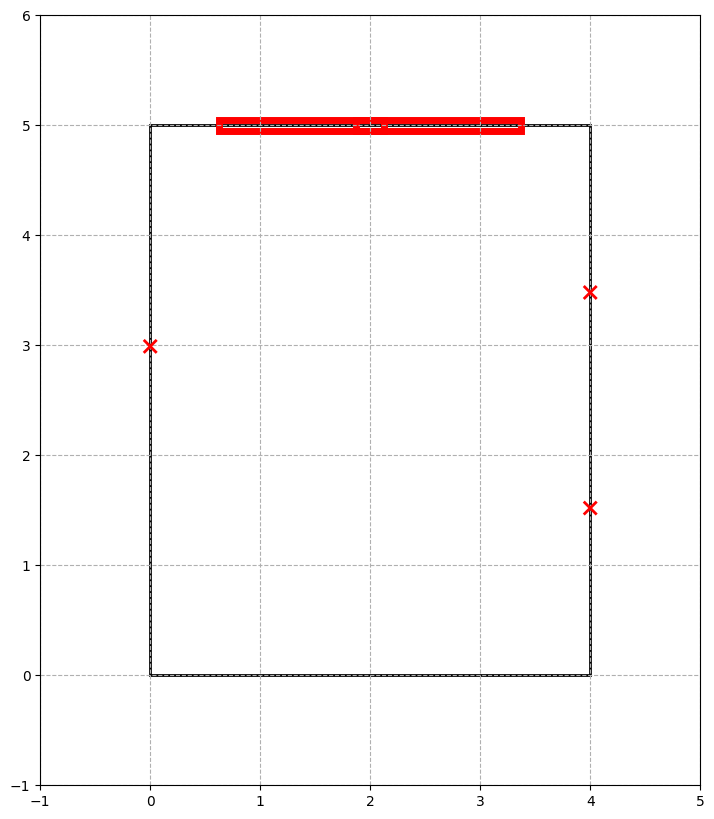

New best result found. Cost:  4.985269521995356e-09


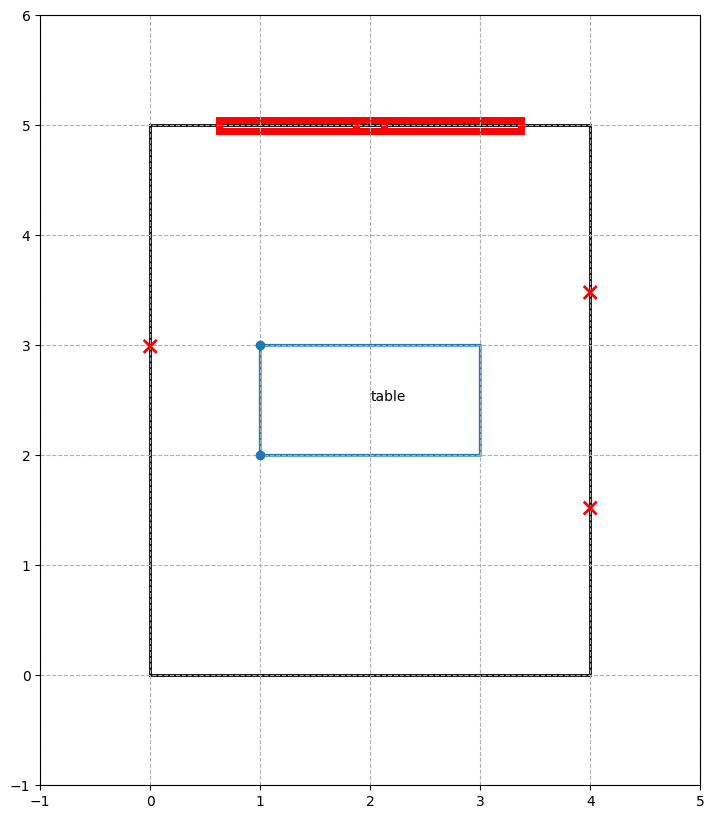

New best result found. Cost:  9.224956424952351 overlap:  0.007266153565772041 bounds:  0
New best result found. Cost:  6.580844542081393 overlap:  0.0004540986352899022 bounds:  0
New best result found. Cost:  6.294928619139113 overlap:  0.007410702767506378 bounds:  0
New best result found. Cost:  3.805701875130316 overlap:  0 bounds:  0


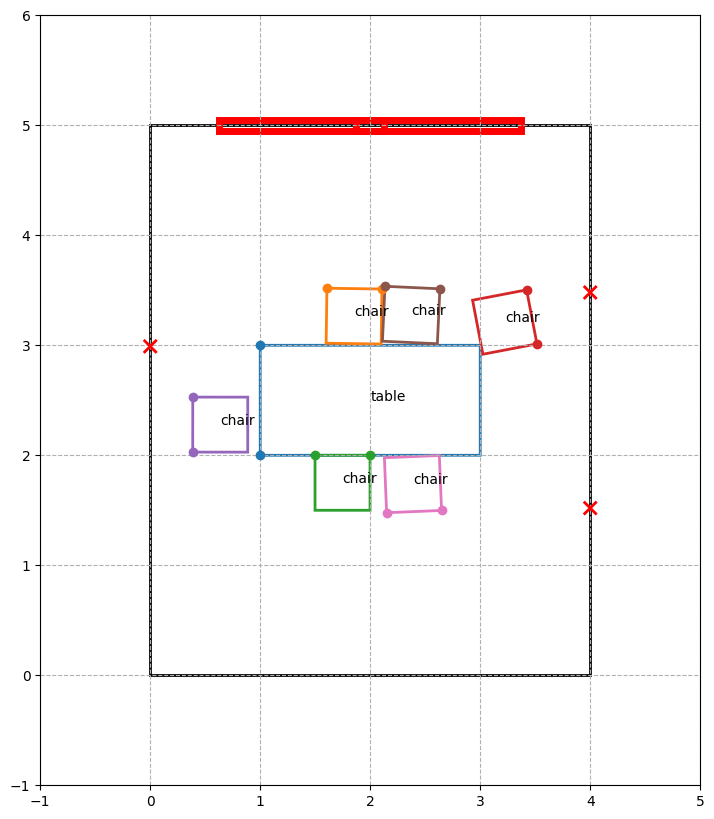

In [4]:
room = create_room(4, 5)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(room, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.7)
room.draw()

options = {'maxiter': 300, 'ftol': 1e-6}
region_setup(room, 'dining', 0)
create_moving_object(room, 'table', 1, 2, 'dining', 0)

def optimize_primary_objects(positions, room): 
    
    output = 0
    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += balanced(positions, room)
    output += aligned(positions, room)

    return output

iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 50:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects, positions, args = (room), method = 'SLSQP', options = options) 
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.4:
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)

    
for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
room.draw() 

room.regions[0].x, room.regions[0].y = room.moving_objects[0].position[0], room.moving_objects[0].position[1]
prev_cost = min_fun 

room.fm_indices += [0]

for i in range(6): 
    create_moving_object(room, 'chair', 0.5, 0.5, 'dining', i+1)

def optimize_secondary_objects(positions, room):
    output = 0

    #output += ind_accessible(positions, room, 0, ['left', 'front', 'right', 'back'])  # table
    output += io_surround(positions, room, 0, [i for i in range(1, 7)])  # table, chairs
    # for i in range(1, 7):
    #      output += io_facing(positions, room, i, 0)

    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    output += balanced(positions, room)
    output += aligned(positions, room)

    return output

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 5e-2 and iters < 50:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 1e-2 and not in_bounds(res.x, room) > 0.4:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 
room.draw() 

room.regions[0].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'sleeping'])
room.regions[0].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'sleeping'])

room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]
prev_cost = min_fun 